### Importing Of Libraries and Modules

In [59]:
# Core Library modules
import os  # Operating system interactions, such as reading and writing files.
import shutil  # High-level file operations like copying and moving files.
import random  # Random number generation for various tasks.
import textwrap  # Formatting text into paragraphs of a specified width.
import warnings  # Warning control context manager.
import zipfile  # Work with ZIP archives.
import platform  # Access to underlying platform’s identifying data.
import itertools  # Functions creating iterators for efficient looping.
from dataclasses import dataclass  # Class decorator for adding special methods to classes.

# PyTorch and Deep Learning Libaries
import torch  # Core PyTorch library for tensor computations.
import torch.nn as nn  # Neural network module for defining layers and architectures.
from torch.nn import functional as F  # Functional module for defining functions and loss functions.
import torch.optim as optim  # Optimizer module for training models (SGD, Adam, etc.).
from torch.utils.data import Dataset, DataLoader, Subset, random_split  # Data handling and batching
import torchvision  # PyTorch's computer vision library.
from torchvision import datasets, transforms  # Image datasets and transformations.
import torchvision.datasets as datasets  # Specific datasets for vision tasks.
import torchvision.transforms as transforms  # Transformations for image preprocessing.
from torchvision.utils import make_grid  # Grid for displaying images.
import torchvision.models as models  # Pretrained models for transfer learning.
from torchvision.datasets import MNIST, EuroSAT  # Standard datasets.
import torchvision.transforms.functional as TF  # Functional transformations.
from torchvision.models import ResNet18_Weights  # ResNet-18 model with pretrained weights.
from torchsummary import summary  # Model summary.
import torchmetrics  # Model evaluation metrics.
from torchmetrics import MeanMetric, Accuracy  # Accuracy metrics.
from torchmetrics.classification import (
    MultilabelF1Score, MultilabelRecall, MultilabelPrecision, MultilabelAccuracy
)  # Classification metrics.
from torchviz import make_dot  # Model visualization.
from torchvision.ops import sigmoid_focal_loss  # Focal loss for class imbalance.
from torchcam.methods import GradCAM  # Grad-CAM for model interpretability.
from torchcam.utils import overlay_mask  # Overlay mask for visualizations.
import pytorch_lightning as pl  # Training management.
from pytorch_lightning.callbacks import ModelCheckpoint, LearningRateMonitor, EarlyStopping, Callback  # Callbacks.
from pytorch_lightning.loggers import TensorBoardLogger  # Logger for TensorBoard.

# Geospatial Data Processing Libraries
import rasterio  # Reading and writing geospatial raster data.
from rasterio.warp import calculate_default_transform, reproject  # Reprojection and transformation.
from rasterio.enums import Resampling  # Resampling for raster resizing.
from rasterio.plot import show  # Visualization of raster data.

# Data Manipulation, Analysis and Visualization Libraries
import pandas as pd  # Data analysis and manipulation.
import numpy as np  # Array operations and computations.
from sklearn.metrics import confusion_matrix, accuracy_score  # Evaluation metrics.
import matplotlib.pyplot as plt  # Static and interactive plotting.
import seaborn as sns  # High-level interface for statistical graphics.

# Utility Libraries
from tqdm import tqdm  # Progress bar for loops.
from PIL import Image  # Image handling and manipulation.
import ast  # Parsing Python code.
import requests  # HTTP requests.
import zstandard as zstd  # Compression and decompression.
from collections import Counter  # Counting hashable objects.
import certifi  # Certificates for HTTPS.
import ssl  # Secure connections.
import urllib.request  # URL handling.
import kaggle  # Kaggle API for datasets.
from IPython.display import Image  # Display images in notebooks.
from pathlib import Path # File system path handling.
from typing import Dict, List, Tuple  # Type hints.
import sys  # System-specific parameters and functions.
import time # Time access and conversions.

# Custom Libraries

### Setting Seed and Device

In [60]:
# Set seed for reproducibility
SEED = 42  
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.set_float32_matmul_precision('medium')

# Render plots
%matplotlib inline

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device} {'(GPU: ' + torch.cuda.get_device_name(0) + ')' if device.type == 'cuda' else ''}")

Device: cuda (GPU: NVIDIA GeForce RTX 3050)


### Defining Config Data Classes

In [61]:
@dataclass
class DatasetConfig:
    dataset_path: str = r'C:\Users\isaac\Desktop\BigEarthTests\Subsets\50%'
    combined_path: str = r'C:\Users\isaac\Desktop\BigEarthTests\Subsets\50%\CombinedRGBImages'
    metadata_path: str =r'C:\Users\isaac\Desktop\BigEarthTests\Subsets\metadata_50_percent.csv'
    metadata_csv = pd.read_csv(metadata_path)
    img_size: int = 120
    img_mean, img_std = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]
    num_classes: int = 19
    band_channels: int = 3 #13
    valid_pct: float = 0.1

@dataclass
class ModelConfig:
    batch_size: int = 32
    num_epochs: int = 10
    model_name: str = 'resnet18'
    num_workers: int = 2 #os.cpu_count() // 2

    train_transforms = transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=DatasetConfig.img_mean, std=DatasetConfig.img_std)
    ])

    val_transforms = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=DatasetConfig.img_mean, std=DatasetConfig.img_std)
    ])

    test_transforms = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=DatasetConfig.img_mean, std=DatasetConfig.img_std)
    ])


In [62]:
# Check if the labels are strings and need to be converted
if isinstance(DatasetConfig.metadata_csv['labels'].iloc[0], str):
    DatasetConfig.metadata_csv['labels'] = DatasetConfig.metadata_csv['labels'].apply(ast.literal_eval)

# Get unique class labels
class_labels = DatasetConfig.metadata_csv['labels'].explode().unique()

# Create a dictionary mapping class labels to indices
class_labels_dict = {label: idx for idx, label in enumerate(class_labels)}

# Create a reversed dictionary mapping indices to class labels
reversed_class_labels_dict = {idx: label for label, idx in class_labels_dict.items()}

print(class_labels_dict)
print(reversed_class_labels_dict)

{'Arable land': 0, 'Broad-leaved forest': 1, 'Land principally occupied by agriculture, with significant areas of natural vegetation': 2, 'Pastures': 3, 'Urban fabric': 4, 'Complex cultivation patterns': 5, 'Mixed forest': 6, 'Industrial or commercial units': 7, 'Coniferous forest': 8, 'Transitional woodland, shrub': 9, 'Natural grassland and sparsely vegetated areas': 10, 'Inland waters': 11, 'Marine waters': 12, 'Inland wetlands': 13, 'Moors, heathland and sclerophyllous vegetation': 14, 'Permanent crops': 15, 'Agro-forestry areas': 16, 'Beaches, dunes, sands': 17, 'Coastal wetlands': 18}
{0: 'Arable land', 1: 'Broad-leaved forest', 2: 'Land principally occupied by agriculture, with significant areas of natural vegetation', 3: 'Pastures', 4: 'Urban fabric', 5: 'Complex cultivation patterns', 6: 'Mixed forest', 7: 'Industrial or commercial units', 8: 'Coniferous forest', 9: 'Transitional woodland, shrub', 10: 'Natural grassland and sparsely vegetated areas', 11: 'Inland waters', 12: '

In [63]:
def encode_label(label: list, num_classes=DatasetConfig.num_classes):
    target = torch.zeros(num_classes)
    for l in label:
        if l in class_labels_dict:
            target[class_labels_dict[l]] = 1.0
    return target

def decode_target(
    target: list,
    text_labels: bool = False,
    threshold: float = 0.4,
    cls_labels: dict = None,
):
    result = []
    for i, x in enumerate(target):
        if x >= threshold:
            if text_labels:
                result.append(cls_labels[i] + "(" + str(i) + ")")
            else:
                result.append(str(i))
    return " ".join(result)

### Defining the Dataset Class

In [64]:
class BigEarthNetSubset(Dataset):
    def __init__(self, df, root_dir, transform=None):
        self.df = df
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = list(Path(root_dir).rglob("*.tif"))
        self.metadata = pd.read_csv(DatasetConfig.metadata_path)

        # Create a mapping from patch_id to labels
        self.patch_to_labels = dict(zip(self.metadata['patch_id'], self.metadata['labels']))
        self.image_paths = list(Path(root_dir).rglob("*.tif"))
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        image_path = self.image_paths[index]
        with rasterio.open(image_path) as src:
            image = src.read([1, 2, 3])
        image = np.transpose(image, (1, 2, 0))
        image = Image.fromarray(image.astype('uint8'), 'RGB')
        if self.transform:
            image = self.transform(image)
        
        label = self.get_label(image_path)  

        return image, label
    
    def get_label(self, image_path):
        patch_id = image_path.stem
        labels = self.patch_to_labels.get(patch_id, None)
        if labels is None:
            return torch.zeros(DatasetConfig.num_classes)  # Return an all-zero tensor as a fallback
    
        # Convert the labels string to an actual list if needed
        if isinstance(labels, str):
            labels = ast.literal_eval(labels) 
    
        encoded = encode_label(labels)
        return encoded

In [65]:
train_df = DatasetConfig.metadata_csv[DatasetConfig.metadata_csv['split'] == 'train']

train_dataset = BigEarthNetSubset(df=train_df, root_dir=DatasetConfig.combined_path, transform=ModelConfig.train_transforms)
print(f"Dataset length: {len(train_dataset)}")

Dataset length: 1195


In [66]:
from PIL import Image
image, label = train_dataset[5]
print(f"Image shape: {image.size}, Label: {label}")

Image shape: <built-in method size of Tensor object at 0x000001DC3581C290>, Label: tensor([0., 1., 0., 0., 0., 0., 1., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0.])


In [67]:
print(train_dataset)

In [68]:
image

tensor([[[-1.8782, -1.8782, -1.8782,  ..., -1.7754, -1.7583, -1.7583],
         [-1.8782, -1.8782, -1.8782,  ..., -1.7754, -1.7583, -1.7583],
         [-1.8782, -1.8782, -1.8782,  ..., -1.7925, -1.7754, -1.7754],
         ...,
         [-1.8953, -1.8953, -1.8953,  ..., -1.8610, -1.8610, -1.8610],
         [-1.8953, -1.8953, -1.8953,  ..., -1.8610, -1.8439, -1.8439],
         [-1.8953, -1.8953, -1.8953,  ..., -1.8610, -1.8439, -1.8439]],

        [[-1.5805, -1.5805, -1.5805,  ..., -1.2829, -1.2654, -1.2654],
         [-1.5805, -1.5805, -1.5805,  ..., -1.2829, -1.2654, -1.2654],
         [-1.5805, -1.5805, -1.5805,  ..., -1.3004, -1.2829, -1.2829],
         ...,
         [-1.5455, -1.5455, -1.5455,  ..., -1.5280, -1.5280, -1.5280],
         [-1.5455, -1.5455, -1.5455,  ..., -1.5280, -1.5105, -1.5105],
         [-1.5455, -1.5455, -1.5455,  ..., -1.5280, -1.5105, -1.5105]],

        [[-1.6302, -1.6302, -1.6476,  ..., -1.5256, -1.5081, -1.5081],
         [-1.6302, -1.6302, -1.6476,  ..., -1

### Defining the Data Modules

In [69]:
class BigEarthNetSubsetDataModule(pl.LightningDataModule):    
    def setup(self, stage=None):
        self.train_transform = ModelConfig.train_transforms
        self.val_transform = ModelConfig.val_transforms
        self.test_transform = ModelConfig.test_transforms

        # Split the dataset
        train_df = DatasetConfig.metadata_csv[DatasetConfig.metadata_csv['split'] == 'train']
        val_df = DatasetConfig.metadata_csv[DatasetConfig.metadata_csv['split'] == 'validation']
        test_df = DatasetConfig.metadata_csv[DatasetConfig.metadata_csv['split'] == 'test']

        self.train_dataset = BigEarthNetSubset(df=train_df, root_dir=DatasetConfig.combined_path, transform=self.train_transform)
        self.val_dataset = BigEarthNetSubset(df=val_df, root_dir=DatasetConfig.combined_path, transform=self.val_transform)
        self.test_dataset = BigEarthNetSubset(df=test_df, root_dir=DatasetConfig.combined_path, transform=self.test_transform)
        print(f"Number of samples in train set: {len(self.train_dataset)}, val set: {len(self.val_dataset)}, test set: {len(self.test_dataset)}")

    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=ModelConfig.batch_size, num_workers=ModelConfig.num_workers, pin_memory=True, shuffle=True, persistent_workers=True)

    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=ModelConfig.batch_size, num_workers=0, pin_memory=True)

    def test_dataloader(self):
        return DataLoader(self.test_dataset, batch_size=ModelConfig.batch_size, num_workers=ModelConfig.num_workers, pin_memory=True, persistent_workers=True)

In [70]:
data_module = BigEarthNetSubsetDataModule()
data_module.setup()


Number of samples in train set: 1195, val set: 606, test set: 551


In [71]:
valid_df = DatasetConfig.metadata_csv[DatasetConfig.metadata_csv['split'] == 'validation']

valid_dataset = BigEarthNetSubset(df=valid_df, root_dir=DatasetConfig.combined_path, transform=ModelConfig.val_transforms)
print(f"Dataset length: {len(valid_dataset)}")

Dataset length: 606


In [72]:
def denormalize(tensors, *, mean, std):
    for c in range(DatasetConfig.band_channels):
        tensors[:, c, :, :].mul_(std[c]).add_(mean[c])

    return torch.clamp(tensors, min=0.0, max=1.0)

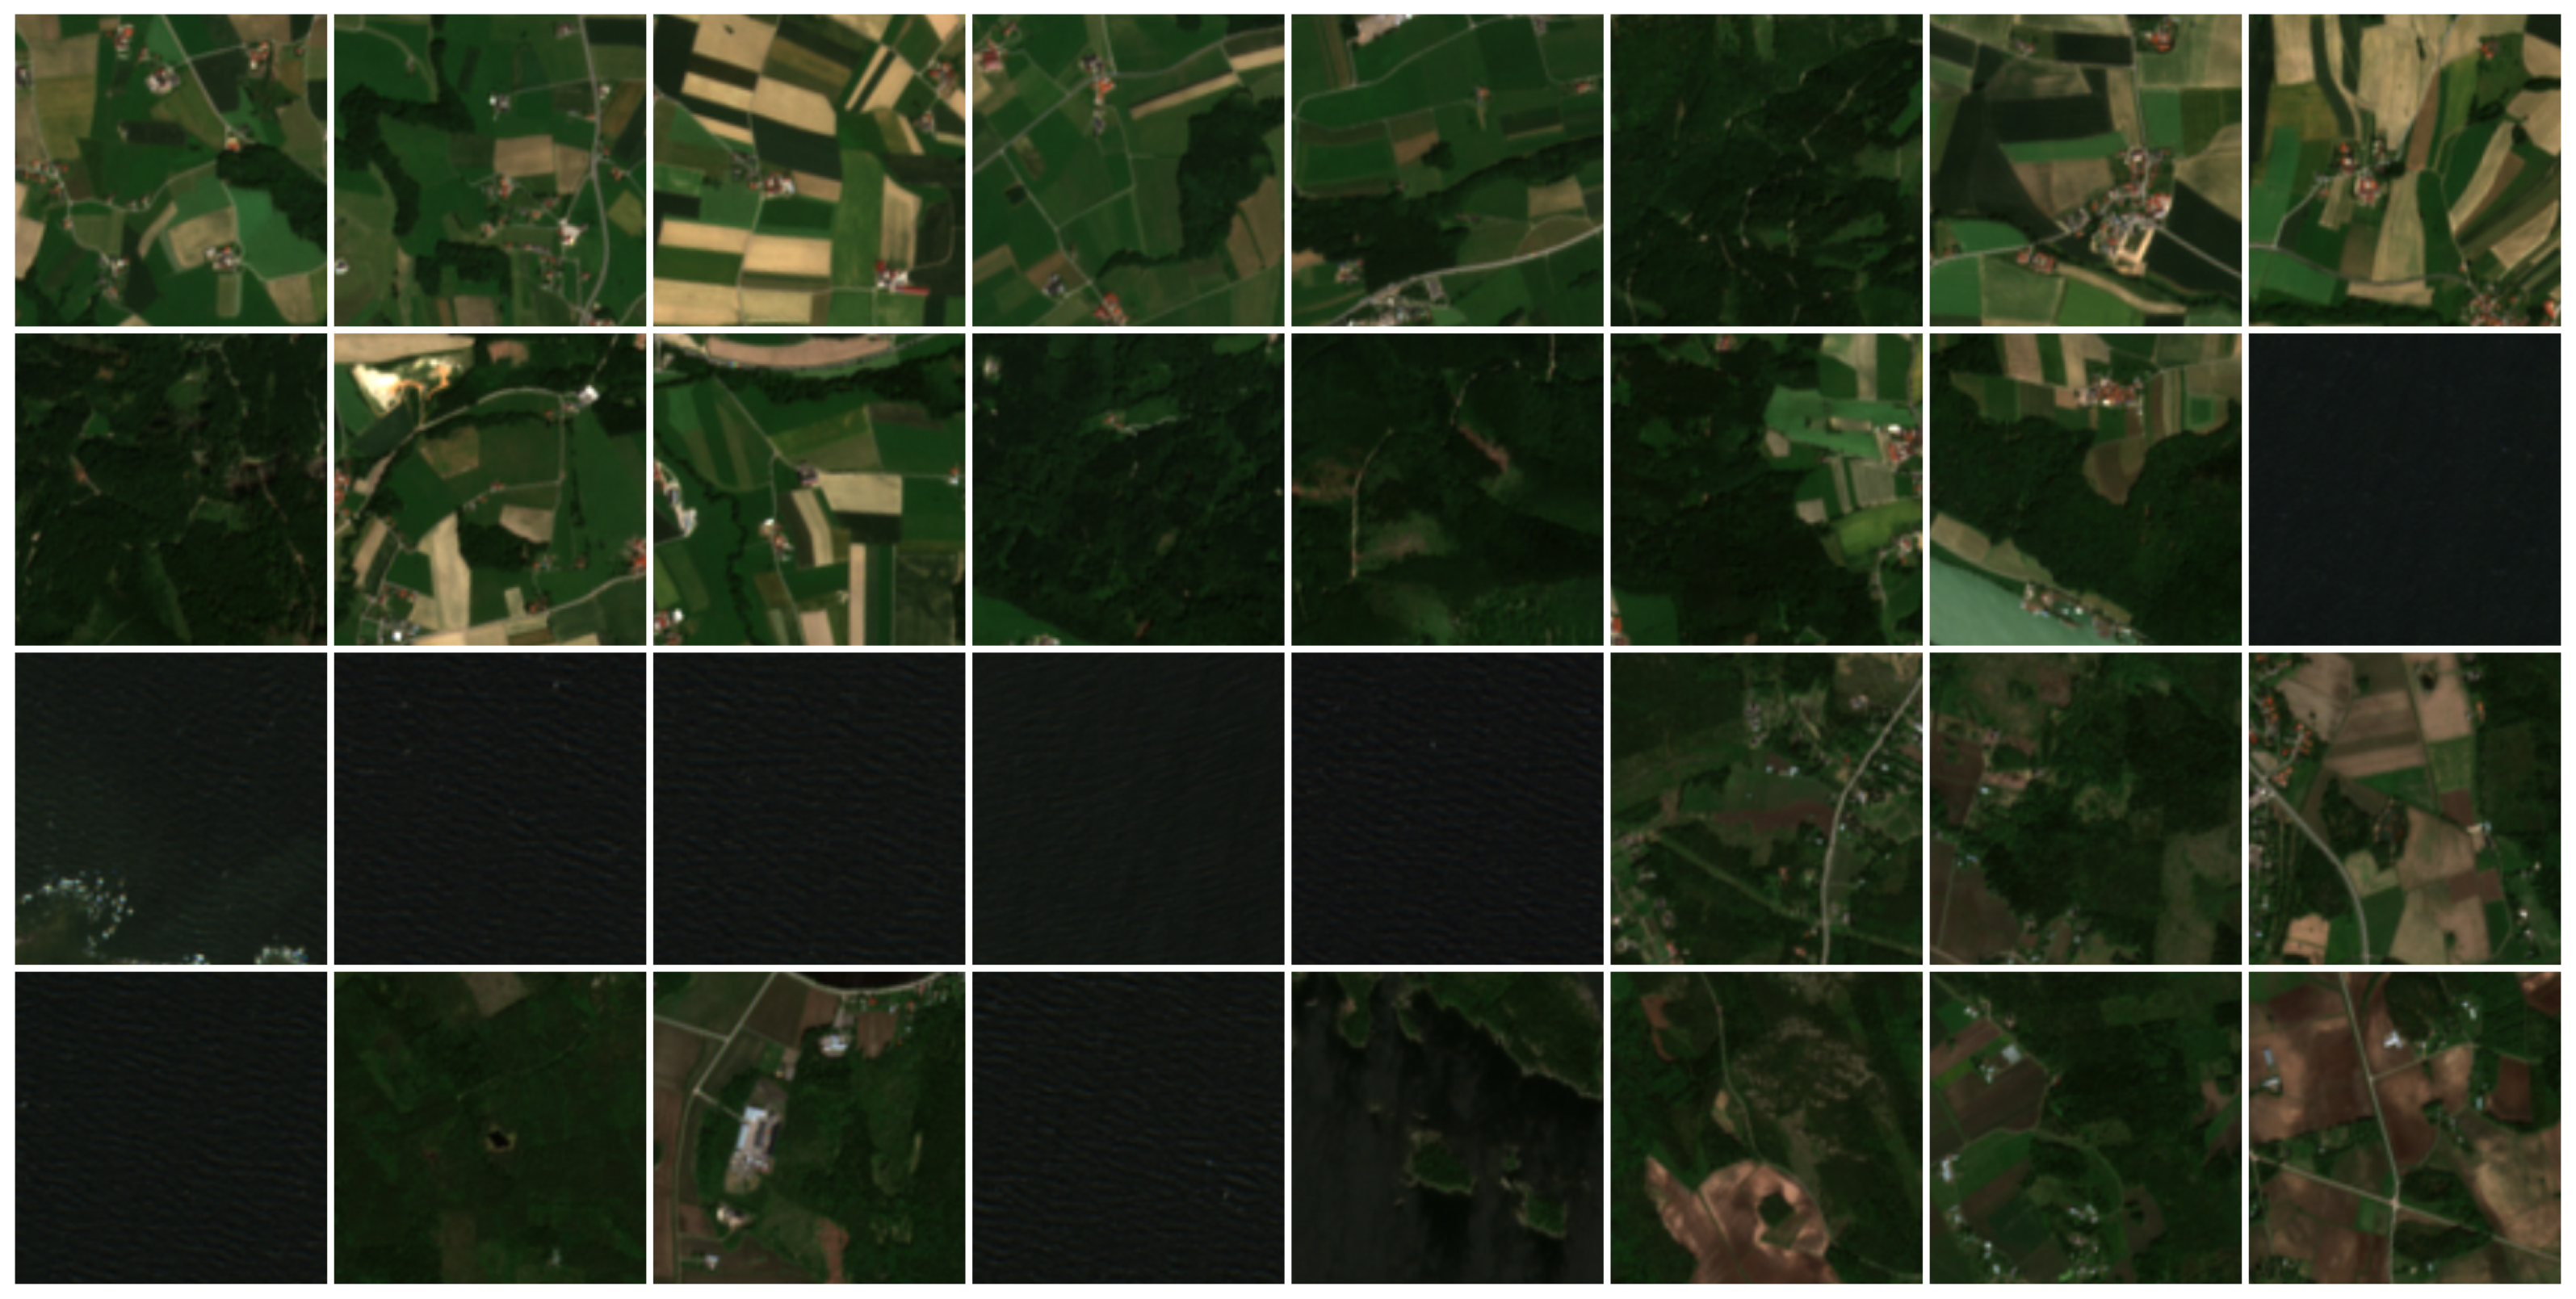

In [73]:
# Load the first batch
validation_loader = data_module.val_dataloader()
batch = next(iter(validation_loader))

images = denormalize(batch[0], mean=DatasetConfig.img_mean, std=DatasetConfig.img_std)

plt.figure(figsize=(32, 32))

grid_img = make_grid(images, nrow=8, padding=5, pad_value=1.0)

plt.imshow(grid_img.permute(1, 2, 0))
plt.axis("off")
#plt.savefig("bigEarthNet.png", bbox_inches='tight')
plt.tight_layout()
plt.show()
plt.close;

### Defining the model

In [74]:
class BigEarthNetSubsetModel(pl.LightningModule):
    def __init__(self):
        super(BigEarthNetSubsetModel, self).__init__()
        # Load the ResNet-18 model
        self.model = models.resnet18(weights=None)
        # Modify the final layer to output 19 classes
        self.model.fc = nn.Linear(self.model.fc.in_features, DatasetConfig.num_classes)
        # Addition of a sigmoid activation function for muylti-label classification
        self.sigmoid = nn.Sigmoid()
        # Passing the model to the GPU
        self.model.to(device)

        # Accuracy metrics
        self.train_acc = MultilabelAccuracy(num_labels=DatasetConfig.num_classes)
        self.val_acc = MultilabelAccuracy(num_labels=DatasetConfig.num_classes)
        self.test_acc = MultilabelAccuracy(num_labels=DatasetConfig.num_classes)

        # Recall metrics
        self.train_recall = MultilabelRecall(num_labels=DatasetConfig.num_classes)
        self.val_recall = MultilabelRecall(num_labels=DatasetConfig.num_classes)
        self.test_recall = MultilabelRecall(num_labels=DatasetConfig.num_classes)

        # Precision metrics
        self.train_precision = MultilabelPrecision(num_labels=DatasetConfig.num_classes)
        self.val_precision = MultilabelPrecision(num_labels=DatasetConfig.num_classes)
        self.test_precision = MultilabelPrecision(num_labels=DatasetConfig.num_classes)

        # F1 Score metrics
        self.train_f1 = MultilabelF1Score(num_labels=DatasetConfig.num_classes)
        self.val_f1 = MultilabelF1Score(num_labels=DatasetConfig.num_classes)
        self.test_f1 = MultilabelF1Score(num_labels=DatasetConfig.num_classes)

        torch.summary(self.model, (DatasetConfig.band_channels, ModelConfig.img_size, ModelConfig.img_size))

    def forward(self, x):
        return self.model(x)
    
    def cross_entropy_loss(self, logits, labels):
        return F.binary_cross_entropy_with_logits(logits, labels)
    
    def configure_optimizers(self):
        optimizer = optim.Adam(self.model.parameters(), lr=0.001)
        return optimizer

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self.forward(x)
        loss = self.cross_entropy_loss(logits, y)
        acc = self.train_acc(logits, y)
        recall = self.train_recall(logits, y)
        f1 = self.train_f1(logits, y)
        precision = self.train_precision(logits, y)

        self.log('train_loss', loss, on_step=True, on_epoch=True, prog_bar=True)
        self.log('train_acc', acc, on_step=True, on_epoch=True, prog_bar=True)
        self.log('train_recall', recall, on_step=True, on_epoch=True, prog_bar=True)
        self.log('train_f1', f1, on_step=True, on_epoch=True, prog_bar=True)
        self.log('train_precision', precision, on_step=True, on_epoch=True, prog_bar=True)

        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self.forward(x)
        loss = self.cross_entropy_loss(logits, y)
        acc = self.val_acc(logits, y)
        recall = self.val_recall(logits, y)
        f1 = self.val_f1(logits, y)
        precision = self.val_precision(logits, y)

        self.log('val_loss', loss, on_epoch=True, prog_bar=True)
        self.log('val_acc', acc, on_epoch=True, prog_bar=True)
        self.log('val_recall', recall, on_epoch=True, prog_bar=True)
        self.log('val_f1', f1, on_epoch=True, prog_bar=True)
        self.log('val_precision', precision, on_step=True, on_epoch=True, prog_bar=True)

        return loss

    def test_step(self, batch, batch_idx):
        x, y = batch
        logits = self.forward(x)
        loss = self.cross_entropy_loss(logits, y)
        acc = self.test_acc(logits, y)
        recall = self.test_recall(logits, y)
        f1 = self.test_f1(logits, y)
        precision = self.test_precision(logits, y)

        self.log('test_loss', loss, on_epoch=True, prog_bar=True)
        self.log('test_acc', acc, on_epoch=True, prog_bar=True)
        self.log('test_recall', recall, on_epoch=True, prog_bar=True)
        self.log('test_f1', f1, on_epoch=True, prog_bar=True)
        self.log('test_precision', precision, on_epoch=True, prog_bar=True)
        
        return loss

### Defining the Callback Class

In [75]:
class BigEarthNetSubsetCallback(Callback):
    def __init__(self, checkpoint_path, model_name):
        self.checkpoint_path = checkpoint_path
        self.model_name = model_name

    def on_epoch_end(self, trainer, pl_module):
        epoch = trainer.current_epoch
        checkpoint_path = os.path.join(self.checkpoint_dir, f"epoch={epoch}_{self.model_name}.ckpt")
        torch.save(pl_module.state_dict(), checkpoint_path)
        print(f"Checkpoint saved at: {checkpoint_path}")

    def on_train_end(self, trainer, pl_module):
        base_path = os.path.join(self.checkpoint_dir, f"final_{self.model_name}")
        final_model_path = f"{base_path}.ckpt"
        counter = 1
        
        # Check if the path exists and increment the counter until a unique path is found
        while os.path.exists(final_model_path):
            final_model_path = f"{base_path}_{counter}.ckpt"
            counter += 1
        
        torch.save(pl_module.state_dict(), final_model_path)
        print(f"Final model saved at: {final_model_path}")

In [76]:
dm = BigEarthNetSubsetDataModule()
dm.setup()

Number of samples in train set: 1195, val set: 606, test set: 551


In [77]:
model = BigEarthNetSubsetModel()

AttributeError: module 'torch' has no attribute 'summary'